In [282]:
# import necessary libraries

#https://codelabs.developers.google.com/codelabs/fraud-detection-ai-explanations?hl=en#0
#he Explainable AI SDK and Copy Model to Deploy

#https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/introduction_to_tensorflow/solutions/preprocessing_layers.ipynb


import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,DenseFeatures


from google.cloud import bigquery
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

tf.__version__

'2.11.0'

In [283]:
#!gsutil cp gs://smart-ml-pongthorn/incident-train-data/TrainEval_Incident.csv data

In [284]:
cateCols=['sla','product_type','brand','service_type','incident_type']
numbericCols=['open_to_close_hour','response_to_resolved_hour']

unusedCols=['severity_id','severity_name','label_binary_severity']
labelCol='label_multi_severity'


model_dir='tf1_multi_model'

# df['label_multi_severity'] =df['severity_name'].map({'Cosmatic':0,'Minor': 1, "Major": 2, "Critical": 3}) 

In [285]:
def load_ml_data(data_path):
 df=pd.read_csv(data_path)
 df =df.drop(columns=unusedCols)
 return df
    
root_path='../../data'    
train = load_ml_data(f"{root_path}/train_incident.csv")
# val=train.copy()
val=load_ml_data(f"{root_path}/validation_incident.csv")
# test =val.copy()
test =load_ml_data(f"{root_path}/test_incident.csv")

labelList=list(train[labelCol].unique())
print(labelList)
nLabel=len(labelList)
print(f"No target label : {nLabel}")

# sr_predict=df.iloc[-1,:]
# df=df.iloc[0:len(df)-1,:]
                 
print(train.info())
train.tail()

[2, 1, 3, 0]
No target label : 4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1714 entries, 0 to 1713
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sla                        1714 non-null   object 
 1   product_type               1714 non-null   object 
 2   brand                      1714 non-null   object 
 3   service_type               1714 non-null   object 
 4   incident_type              1714 non-null   object 
 5   open_to_close_hour         1714 non-null   float64
 6   response_to_resolved_hour  1714 non-null   float64
 7   label_multi_severity       1714 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 107.2+ KB
None


,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,label_multi_severity
1709,8x5 4Hrs Response Time,Storage,NetApp,Incident,Hard Disk Drive Failure,47.966667,5.000000,2
1710,24x7 4Hrs Response Time,Storage,NetApp,Incident,Hard Disk Drive Failure,7.716667,4.683333,2
1711,24x7 4Hrs Response Time,Storage,NetApp,Incident,Hard Disk Drive Failure,18.000000,18.000000,1
1712,24x7 4Hrs Resolution Time,Hardware,Oracle,Incident,System Board Failure,287.000000,285.733333,2
1713,24x7 4Hrs Resolution Time,Storage,NetApp,Incident,Hard Disk Drive Failure,8.983333,8.550000,1


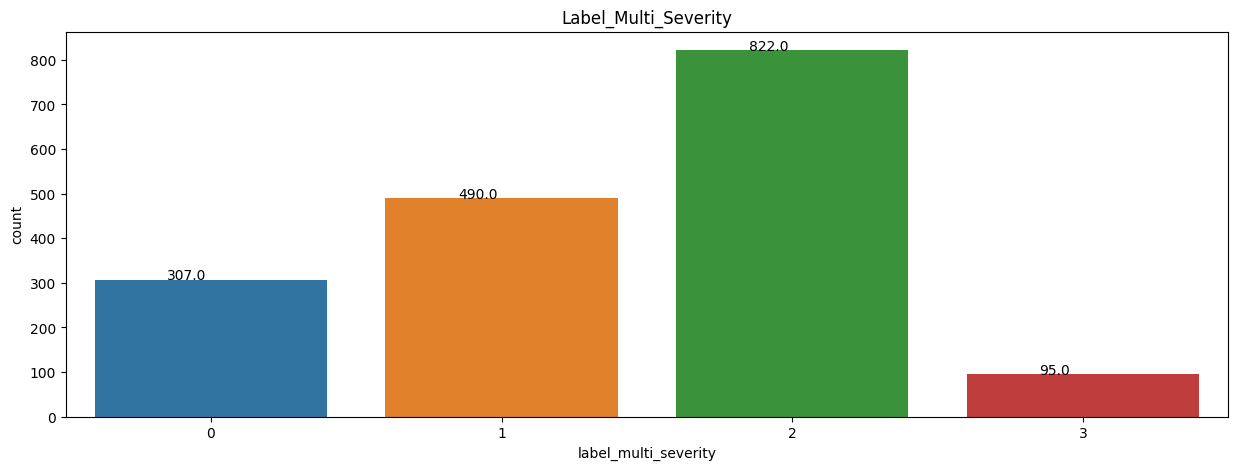

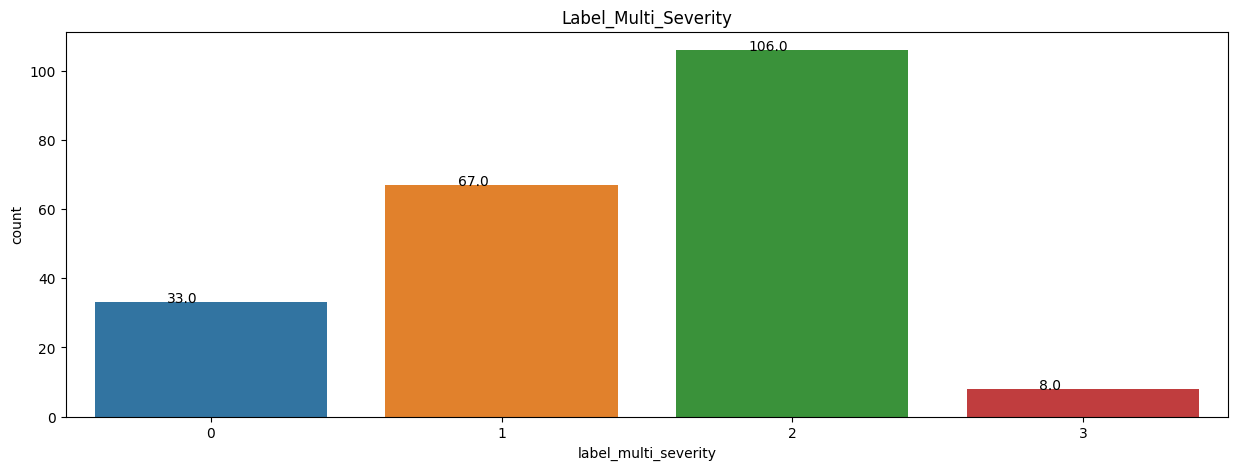

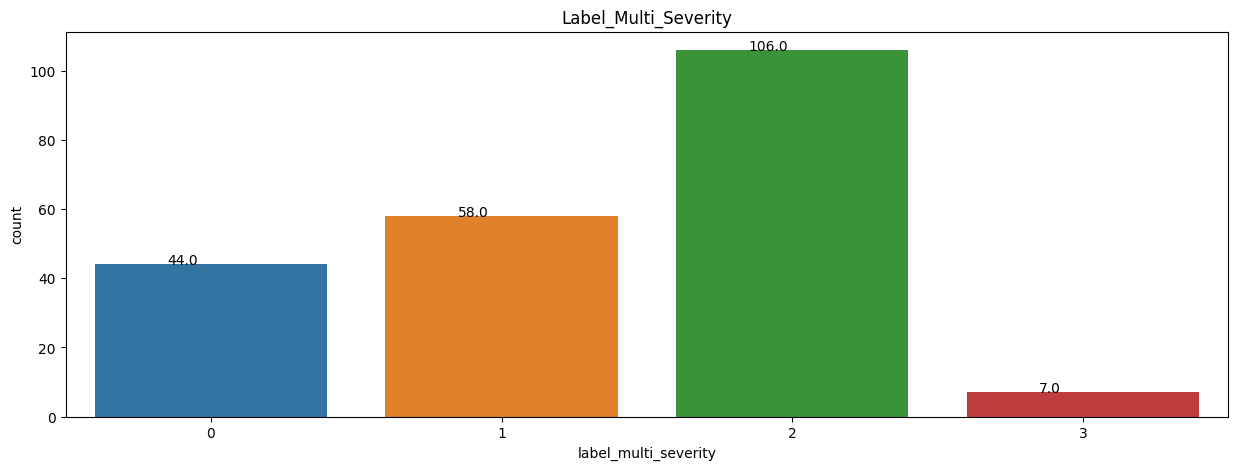

In [286]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(15,5))
    ax =sns.countplot(x=labelCol, data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title(labelCol.title())
    plt.show()
    
plot_class(train)
plot_class(val)
plot_class(test)

In [287]:
# labelsTRain  = tf.keras.utils.to_categorical(train[labelCol], num_classes=nLabel)
# print(type(labelsTRain))


In [288]:
def multiple_label_df_to_dataset(dataframe, shuffle=True, batch_size=32):
  features = dataframe.copy()
  labels = features.pop(labelCol)
  labels  = tf.keras.utils.to_categorical(labels, num_classes=nLabel)
    
  ds = tf.data.Dataset.from_tensor_slices(( dict(features), labels ))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(features))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds
     
     

In [289]:
print("Explore Data from Tensor before keras data processing")
batch_size = 5
train_ds =multiple_label_df_to_dataset(train, batch_size=batch_size)

[(train_features, label_batch)] = train_ds.take(1)
print("========Features==========")
print('Every feature:', list(train_features.keys()))
print('product_type:', train_features['product_type'])
print('open_to_close_hour:', train_features['open_to_close_hour'])
print("========Labels==========")
print(f'{label_batch }')

Explore Data from Tensor before keras data processing
========Features==========
Every feature: ['sla', 'product_type', 'brand', 'service_type', 'incident_type', 'open_to_close_hour', 'response_to_resolved_hour']
product_type: tf.Tensor([b'Server' b'Storage' b'Software' b'Storage' b'Storage'], shape=(5,), dtype=string)
open_to_close_hour: tf.Tensor([391.55         5.           3.16666667   7.21666667   2.        ], shape=(5,), dtype=float64)
========Labels==========
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [290]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [291]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))
     

In [292]:
hour_col = train_features['open_to_close_hour']
layer = get_normalization_layer('open_to_close_hour', train_ds)
layer(hour_col)

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 1.1219655 , -0.34145623, -0.34839696, -0.33306423, -0.35281378],
      dtype=float32)>

In [293]:
# total no type+unkonw
type_col = train_features['product_type']
layer = get_category_encoding_layer('product_type', train_ds, 'string')
layer(type_col)

<tf.Tensor: shape=(11,), dtype=float32, numpy=array([0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

# Process Data 

In [294]:
batch_size =32
train_ds = multiple_label_df_to_dataset (train, batch_size=batch_size)
# for element in train_ds.as_numpy_iterator():
#     print(element)

In [295]:
val_ds = multiple_label_df_to_dataset(val, batch_size=batch_size)
test_ds = multiple_label_df_to_dataset(test, batch_size=batch_size)

In [296]:
all_inputs = []
encoded_features = []

In [297]:
# Numeric features.
for header in numbericCols:
  print(header)  
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

open_to_close_hour
response_to_resolved_hour


In [298]:
# Categorical features encoded as string.
categorical_cols = cateCols
for header in categorical_cols:
  print(header)  
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string')
                                        
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)


sla
product_type
brand
service_type
incident_type


In [ ]:
all_features = tf.keras.layers.concatenate(encoded_features)

x = tf.keras.layers.Dense(32, activation="relu")(all_features)
# x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
# x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(nLabel,activation=tf.nn.softmax)(x)

model = tf.keras.Model(all_inputs, output)


model.compile(optimizer='adam',loss=tf.keras.losses.CategoricalCrossentropy(),metrics=["accuracy"])
model.summary()    

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history =model.fit(train_ds, validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE,callbacks = [early_stopping])
# history =model.fit(train_ds,verbose=1,validation_data=val_ds,epochs=EPOCHS,batch_size=BATCH_SIZE)


In [ ]:
loss, accuracy = model.evaluate(val_ds)
print("Average Accuracy on Eveluation", accuracy)
loss, accuracy = model.evaluate(test_ds)
print("Average Accuracy  on Test", accuracy)
     

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
model.save(model_dir)


In [ ]:
reloaded_model = tf.keras.models.load_model(model_dir)

In [ ]:
#label_binary_severity
sample={"sla":"24x7 4Hrs Response Time",
        "product_type":"Server",
        "brand":"VMWare",                
        "service_type":"Incident",
        "incident_type":"General Incident",
        "open_to_close_hour":8.50,
        "response_to_resolved_hour":6.000000 \
       }

print(sample)
              
print("===============================================================================================================")    
print("input t0 predict")    
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
print(input_dict)

predictionList = reloaded_model.predict(input_dict)
print(predictionList)
prob = tf.nn.sigmoid(predictionList[0])
print(f"{(100 * prob)} %  as Severity")   

In [ ]:
plt.figure(figsize=(15,8))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'accuracy']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

In [ ]:
# from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder
# import explainable_ai_sdk

# model_builder = SavedModelMetadataBuilder(model_dir)
# metadata = model_builder.get_metadata()
# print(metadata)

In [ ]:
# # Update these to your own GCP project and model
# PROJECT_ID = 'pongthorn'
# REGION = "asia-southeast1"  # @param {type: "string"}
# MODEL_BUCKET = 'gs://tf1-incident-pongthorn'

# !gsutil mb -l$REGION $MODEL_BUCKET

In [ ]:
# !gsutil -m cp -r ./$model_dir/* $MODEL_BUCKET/model

# Deploy the model

In [ ]:
# MODEL = 'tf1_incident'
# VERSION = 'v1'
# model_path = MODEL_BUCKET + '/model'

In [ ]:
# !gcloud ai-platform models create $MODEL --region=$REGION

In [ ]:

# METRICS = [
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'), 
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
# ]
